In [1]:
import os
import pandas as pd
import numpy as np
import time

file_path = "2023_09_2024_08_AQI_Weather_dataset.csv"
data = pd.read_csv(file_path, low_memory = False)
sorted_data = data.sort_values(by = ['sitename', 'datacreationdate'])

In [2]:
sorted_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114192 entries, 0 to 114191
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   datacreationdate  114192 non-null  object 
 1   sitename          114192 non-null  object 
 2   aqi               114192 non-null  float64
 3   so2               114192 non-null  float64
 4   co                114192 non-null  float64
 5   o3                114192 non-null  float64
 6   o3_8hr            114192 non-null  float64
 7   pm10              114192 non-null  float64
 8   pm2.5             114192 non-null  float64
 9   no2               114192 non-null  float64
 10  nox               114192 non-null  float64
 11  no                114192 non-null  float64
 12  co_8hr            114192 non-null  float64
 13  pm2.5_avg         114192 non-null  float64
 14  pm10_avg          114192 non-null  float64
 15  so2_avg           114192 non-null  float64
 16  測站氣壓(hPa)         11

In [3]:
data['datacreationdate'] = pd.to_datetime(data['datacreationdate'])

In [4]:
data.rename(columns={
    '測站氣壓(hPa)': 'station_pressure_hpa',
    '氣溫(℃)': 'temperature_c',
    '相對溼度(%)': 'relative_humidity',
    '風速(m/s)': 'wind_speed_m_s',
    '風向(360degree)': 'wind_direction_deg',
    '降水量(mm)': 'precipitation_mm'
}, inplace=True)

In [5]:
summary = data.describe()
print(summary)

                    datacreationdate            aqi            so2  \
count                         114192  114192.000000  114192.000000   
mean   2024-03-02 00:30:00.000000256      52.573525       1.357898   
min              2023-09-01 01:00:00      -1.000000       0.000000   
25%              2023-12-01 12:45:00      32.000000       0.800000   
50%              2024-03-02 00:30:00      48.000000       1.200000   
75%              2024-06-01 12:15:00      67.000000       1.700000   
max              2024-09-01 00:00:00     169.000000      80.400000   
std                              NaN      26.450290       0.874088   

                  co             o3         o3_8hr           pm10  \
count  114192.000000  114192.000000  114192.000000  114192.000000   
mean        0.366681      28.769889      28.788800      32.425529   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.190000      15.100000      17.000000      18.000000   
50%         0.290000    

In [6]:
class_mapping = {
    'Good': 0,
    'Moderate': 1,
    'Unhealthy for Sensitive Groups': 2,
    'Unhealthy': 3,
    'Very Unhealthy': 4,
    'Hazardous': 5
}

In [7]:
# 定義 AQI 分類函數
def aqi_to_category(aqi):
    if aqi <= 50:
        return 0
    elif aqi <= 100:
        return 1
    elif aqi <= 150:
        return 2
    elif aqi <= 200:
        return 3
    elif aqi <= 300:
        return 4
    else:
        return 5

# 應用到數據
data['AQI_level'] = data['aqi'].apply(aqi_to_category)

In [8]:
# 所有特徵列（根據提供數據結構）
all_features = [
    'station_pressure_hpa', 'temperature_c', 'relative_humidity', 'wind_speed_m_s',
    'wind_direction_deg', 
    'precipitation_mm', 'pm2.5', 'pm10', 'so2', 'no2', 'nox', 'o3', 'co', 'o3_8hr',
    'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg', 'no'
]

# 24hr -> 1hr

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

def train_and_evaluate_xgboost(X, y):
    """
    使用 XGBoost 訓練並評估模型，輸出 Accuracy、F1-score 和 AUROC。
    Args:
        X: 特徵數據。
        y: 目標數據。
    Returns:
        model: 訓練後的 XGBoost 模型。
        results: 評估指標（Accuracy、F1-score、AUROC）。
    """
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 初始化 XGBoost 模型
    model = xgb.XGBClassifier(
        eval_metric="mlogloss",
        random_state=42
    )
    
    # 訓練模型
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # 預測類別
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # 計算評估指標
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    # 嘗試計算 AUROC
    try:
        if len(y_prob.shape) == 1:  # 一維數據 (二分類特例)
            auroc = roc_auc_score(y_test, y_prob)
        elif len(y_prob.shape) == 2:  # 二維數據
            if y_prob.shape[1] == 2:  # 二分類
                auroc = roc_auc_score(y_test, y_prob[:, 1])
            else:  # 多分類
                auroc = roc_auc_score(y_test, y_prob, multi_class="ovr")
    except Exception as e:
        print(f"Error calculating AUROC: {e}")
        auroc = None
    
    # 打印評估指標
    print("Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    if auroc is not None:
        print(f"AUROC: {auroc:.4f}")
    print(classification_report(y_test, y_pred))
    print(f"Training Time: {elapsed_time:.2f} seconds")
    
    # 返回模型和評估結果
    return model, {"accuracy": accuracy, "f1_score": f1, "auroc": auroc, "time": elapsed_time}

def plot_feature_importance(model, feature_names, top_n=10):
    """
    繪製特徵重要性圖。
    Args:
        model: 訓練後的 XGBoost 模型。
        feature_names: 特徵名稱列表。
        top_n: 顯示的特徵數量。
    """
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values(by="importance", ascending=False).head(top_n)
    
    # 繪圖
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["feature"], importance_df["importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Feature Importance")
    plt.gca().invert_yaxis()  # 翻轉 Y 軸，重要特徵在頂部
    plt.show()
    
    return importance_df

Model Performance:
Accuracy: 0.9408
F1-score: 0.9406
AUROC: 0.9941
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     12111
         1.0       0.93      0.93      0.93      9310
         2.0       0.89      0.87      0.88      1298
         3.0       0.80      0.58      0.67        55

    accuracy                           0.94     22774
   macro avg       0.89      0.83      0.86     22774
weighted avg       0.94      0.94      0.94     22774

Training Time: 144.79 seconds


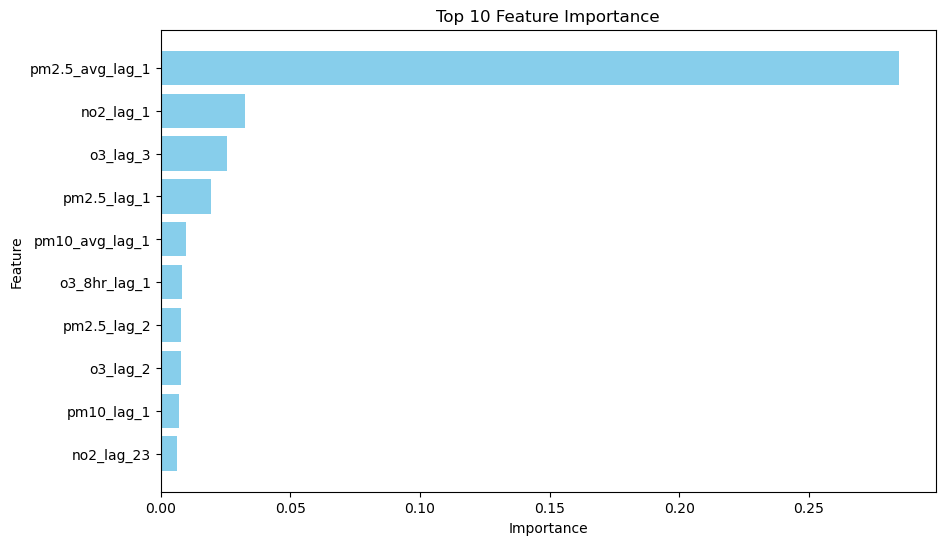

Top 10 Features:
             feature  importance
360  pm2.5_avg_lag_1    0.284637
216        no2_lag_1    0.032378
266         o3_lag_3    0.025519
144      pm2.5_lag_1    0.019494
384   pm10_avg_lag_1    0.009752
312     o3_8hr_lag_1    0.008237
145      pm2.5_lag_2    0.007933
265         o3_lag_2    0.007736
168       pm10_lag_1    0.006915
238       no2_lag_23    0.006373


In [10]:
# 滯後特徵與目標
lag_features = []
for lag in range(1, 25):
    for feature in all_features:
        lag_features.append(data.groupby('sitename')[feature].shift(lag).rename(f'{feature}_lag_{lag}'))

# 合併滯後特徵
lag_features_df = pd.concat(lag_features, axis=1)
data_with_lags = pd.concat([data.reset_index(drop=True), lag_features_df.reset_index(drop=True)], axis=1)

# 添加目標變數
data_with_lags['AQI_level_next'] = data_with_lags.groupby('sitename')['AQI_level'].shift(-1)

# 刪除 NaN
lag_columns_24hr = [f'{feature}_lag_{lag}' for feature in all_features for lag in range(1, 25)]
data_24hr = data_with_lags.dropna(subset=lag_columns_24hr + ['AQI_level_next'])
X_24hr = data_24hr[lag_columns_24hr]
y_24hr = data_24hr['AQI_level_next']

# 訓練並評估 XGBoost
xgboost_model, metrics = train_and_evaluate_xgboost(X_24hr, y_24hr)

# 繪製特徵重要性圖
top_10_features_24hr = plot_feature_importance(xgboost_model, X_24hr.columns, top_n=10)
print("Top 10 Features:")
print(top_10_features_24hr)

# 1hr -> 1hr

Model Performance:
Accuracy: 0.9365
F1-score: 0.9363
AUROC: 0.9930
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     12085
         1.0       0.92      0.93      0.92      9307
         2.0       0.89      0.84      0.86      1298
         3.0       0.81      0.64      0.71        55

    accuracy                           0.94     22745
   macro avg       0.89      0.84      0.86     22745
weighted avg       0.94      0.94      0.94     22745

Training Time: 2.71 seconds


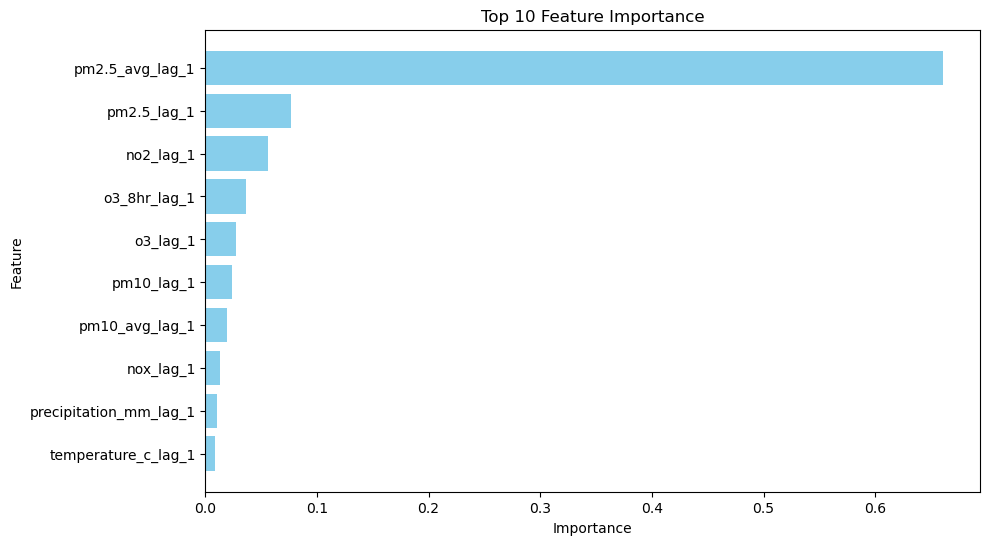

Top 10 Features:
                   feature  importance
15         pm2.5_avg_lag_1    0.661232
6              pm2.5_lag_1    0.076447
9                no2_lag_1    0.056102
13            o3_8hr_lag_1    0.036177
11                o3_lag_1    0.027147
7               pm10_lag_1    0.023446
16          pm10_avg_lag_1    0.019162
10               nox_lag_1    0.013416
5   precipitation_mm_lag_1    0.010327
1      temperature_c_lag_1    0.008907


In [65]:
# 滯後特徵與目標
for feature in all_features:  # all_features 是所有的數據特徵名
    data[f'{feature}_lag_1'] = data.groupby('sitename')[feature].shift(1)

data['AQI_level_next'] = data.groupby('sitename')['AQI_level'].shift(-1)

# 刪除 NaN
lag_columns_1hr = [f'{feature}_lag_1' for feature in all_features]
data_1hr = data.dropna(subset=lag_columns_1hr + ['AQI_level_next'])
X_1hr = data_1hr[lag_columns_1hr]
y_1hr = data_1hr['AQI_level_next']

# 訓練並評估 XGBoost 模型
xgboost_model_1hr, metrics_1hr = train_and_evaluate_xgboost(X_1hr, y_1hr)

# 繪製特徵重要性圖
top_10_features_1hr = plot_feature_importance(xgboost_model_1hr, X_1hr.columns, top_n=10)
print("Top 10 Features:")
print(top_10_features_1hr)

# 24hr -> 24hr

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import pandas as pd

def train_and_evaluate_xgboost_multioutput(X, y):
    """
    使用 MultiOutputClassifier 封裝 XGBoost 訓練並評估模型，適用於多輸出場景。
    Args:
        X: 特徵數據。
        y: 目標數據（多輸出）。
    Returns:
        model: 訓練後的 MultiOutputClassifier 包裝的 XGBoost 模型。
        metrics: 每個輸出的評估指標。
    """
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初始化 XGBoost 多輸出模型
    model = MultiOutputClassifier(xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    ))
    
    # 訓練模型
    model.fit(X_train, y_train)
    
    # 評估每個輸出的性能
    metrics = {}
    for i, column in enumerate(y.columns if hasattr(y, 'columns') else range(y.shape[1])):
        y_pred = model.predict(X_test)[:, i]
        y_prob = model.estimators_[i].predict_proba(X_test)
        
        # 計算指標
        accuracy = accuracy_score(y_test[:, i], y_pred)
        f1 = f1_score(y_test[:, i], y_pred, average="weighted")
        auroc = roc_auc_score(y_test[:, i], y_prob, multi_class="ovr") if len(y_prob.shape) > 1 else None
        
        # 保存結果
        metrics[f"Target {i+1}"] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "auroc": auroc
        }
        
        # 輸出指標
        print(f"Target {i+1}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-score: {f1:.4f}")
        if auroc is not None:
            print(f"  AUROC: {auroc:.4f}")
        print()
    
    return model, metrics


def plot_feature_importance_multioutput(model, feature_names, top_n=10):
    """
    繪製多輸出模型中每個輸出的特徵重要性圖。
    Args:
        model: MultiOutputClassifier 包裝的 XGBoost 模型。
        feature_names: 特徵名稱列表。
        top_n: 顯示的特徵數量。
    """
    for i, estimator in enumerate(model.estimators_):
        importance = estimator.feature_importances_
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "importance": importance
        }).sort_values(by="importance", ascending=False).head(top_n)
        
        # 繪圖
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"], importance_df["importance"], color="skyblue")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title(f"Top {top_n} Feature Importance (Target {i+1})")
        plt.gca().invert_yaxis()
        plt.show()

In [15]:
# 滯後特徵
lag_features = []
for lag in range(1, 3):  # 滯後 24 小時
    for feature in all_features:
        lag_features.append(data.groupby('sitename')[feature].shift(lag).rename(f'{feature}_lag_{lag}'))

# 合併滯後特徵
lag_features_df = pd.concat(lag_features, axis=1)
data_with_lags = pd.concat([data.reset_index(drop=True), lag_features_df.reset_index(drop=True)], axis=1)

# 添加目標變數（未來 24 小時）
for lead in range(1, 3):
    data_with_lags[f'AQI_level_future_{lead}'] = data_with_lags.groupby('sitename')['AQI_level'].shift(-lead)

# 刪除 NaN
future_cols = [f'AQI_level_future_{lead}' for lead in range(1, 3)]
lag_columns_future = [f'{feature}_lag_{lag}' for feature in all_features for lag in range(1, 3)]
data_future = data_with_lags.dropna(subset=lag_columns_future + future_cols)

X_future = data_future[lag_columns_future]
y_future = data_future[future_cols]

X_future = X_future.values 
y_future = y_future.values  


In [16]:
# 訓練並評估 XGBoost 多輸出模型
xgboost_model_future, metrics_future = train_and_evaluate_xgboost_multioutput(X_future, y_future)

C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Target 1:
  Accuracy: 0.9370
  F1-score: 0.9368
  AUROC: 0.9929

Target 2:
  Accuracy: 0.9154
  F1-score: 0.9150
  AUROC: 0.9874



In [53]:
pollutants = ['o3_8hr', 'o3', 'pm2.5_avg', 'pm10_avg', 'co', 'so2', 'no2']

# Step 1: Generate lagged features for all pollutants outside the loop
for pollutant in pollutants:
    data[f'{pollutant}_lag_1'] = data.groupby('sitename')[pollutant].shift(1)

# Step 2: Remove rows with NaN values once for all pollutants
data = data.dropna(subset=[f'{pollutant}_lag_1' for pollutant in pollutants])

# Step 3: Train models for each pollutant
models = {}
predictions = {}

for pollutant in pollutants:
    X = data[[f'{pollutant}_lag_1']]  # Lagged feature for the pollutant
    y = data[pollutant]  # Target is the pollutant's next-hour concentration
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost model
    model = xgb.XGBRegressor(use_label_encoder=False, eval_metric="rmse", random_state=42)
    model.fit(X_train, y_train)
    models[pollutant] = model

    # Predict future concentration
    predictions[pollutant] = model.predict(X_test)

C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\JMU\anaconda3\Lib\site-packages\xgboost\